In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

from utility import *
from model_utility import *

In [3]:
LOOKBACK = 61
TRAIN_SPLIT_RATIO = 0.9
columns = [CLOSE_INDEX]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [4]:
todays_date = datetime.now().strftime('%Y-%m-%d')
download_monthly_klines('spot', [BTC], ['15m'], '2019-01-01', todays_date, 'train')

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-01.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-02.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-03.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-04.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-05.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-06.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-07.zip
[##################################################]
File Download: /kaggle/working/train/BTCUSDT/BTCUSDT-15m-2019-08.zip
[############

In [5]:
dataframe = get_data('train', BTC)

train/BTCUSDT/BTCUSDT-15m-2019-01.csv
train/BTCUSDT/BTCUSDT-15m-2019-02.csv
train/BTCUSDT/BTCUSDT-15m-2019-03.csv
train/BTCUSDT/BTCUSDT-15m-2019-04.csv
train/BTCUSDT/BTCUSDT-15m-2019-05.csv
train/BTCUSDT/BTCUSDT-15m-2019-06.csv
train/BTCUSDT/BTCUSDT-15m-2019-07.csv
train/BTCUSDT/BTCUSDT-15m-2019-08.csv
train/BTCUSDT/BTCUSDT-15m-2019-09.csv
train/BTCUSDT/BTCUSDT-15m-2019-10.csv
train/BTCUSDT/BTCUSDT-15m-2019-11.csv
train/BTCUSDT/BTCUSDT-15m-2019-12.csv
train/BTCUSDT/BTCUSDT-15m-2020-01.csv
train/BTCUSDT/BTCUSDT-15m-2020-02.csv
train/BTCUSDT/BTCUSDT-15m-2020-03.csv
train/BTCUSDT/BTCUSDT-15m-2020-04.csv
train/BTCUSDT/BTCUSDT-15m-2020-05.csv
train/BTCUSDT/BTCUSDT-15m-2020-06.csv
train/BTCUSDT/BTCUSDT-15m-2020-07.csv
train/BTCUSDT/BTCUSDT-15m-2020-08.csv
train/BTCUSDT/BTCUSDT-15m-2020-09.csv
train/BTCUSDT/BTCUSDT-15m-2020-10.csv
train/BTCUSDT/BTCUSDT-15m-2020-11.csv
train/BTCUSDT/BTCUSDT-15m-2020-12.csv
train/BTCUSDT/BTCUSDT-15m-2021-01.csv
train/BTCUSDT/BTCUSDT-15m-2021-02.csv
train/BTCUSD

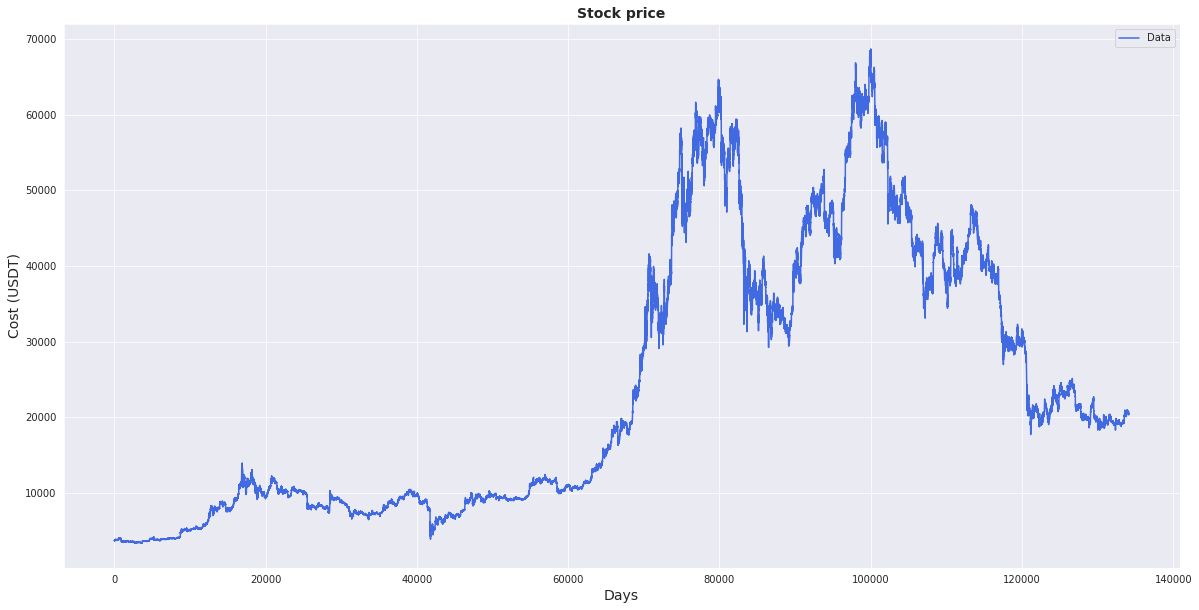

In [6]:
dataframe = dataframe[dataframe[IGNORE_INDEX] == 0]
plot_graph(pd.DataFrame(dataframe[CLOSE_INDEX].values))

In [7]:
scalers = {}
for col in columns:
    scaler = MinMaxScaler().fit(dataframe[[col]])
    dataframe[col] = scaler.transform(dataframe[[col]])
    scalers[col] = scaler

dataframe = dataframe[columns]

In [8]:
x_train, y_train, x_test, y_test = split_data(dataframe, LOOKBACK, TRAIN_SPLIT_RATIO, CLOSE_INDEX-1)

print('x_train.shape = {}'.format(x_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('x_test.shape = {}'.format(x_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

x_train.shape = (120668, 60, 1)
y_train.shape = (120668,)
x_test.shape = (13407, 60, 1)
y_test.shape = (13407,)


In [9]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

2022-11-21 22:11:36.223105: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 22:11:36.224111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 22:11:36.225579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 22:11:36.226727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [10]:
input_dim = x_train.shape[1]
output_dim = 1

batch_size = 64

In [ ]:
train_dataset = CryptocurrencyDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
test_dataset = CryptocurrencyDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
class LSTM_1(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(LSTM_1, self).__init__()

        self.lstm1 = nn.LSTM(60, 256, batch_first=True)
        self.fc1 = nn.Linear(256, 1)
        
    def observe_outputs(self, x):
        x, _ = self.lstm1(x)
        print('After lstm1: {}'.format(x.size()))

        x = self.fc1(x[:, -1, :])
        print('After fc2: {}'.format(x.size()))
        
    def forward(self, x):
        out, _ = self.lstm1(out)
        out = self.fc1(out[:, -1, :])

        return out

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [12]:
def test_forward():
    lstm_1 = LSTM_1(input_dim, output_dim).to(device)

    x = torch.randn(32, 60, 5).to(device)
    with torch.no_grad():
        lstm_1.observe_outputs(x)

test_forward()

In [13]:
num_params = count_parameters(LSTM_1(input_dim, output_dim))
print('Total number of parameters: {}'.format(num_params))

2022-11-21 22:11:43.688409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-21 22:11:46.106348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3771/3771 [==============================] - 27s 6ms/step - loss: 0.0043 - root_mean_squared_error: 0.0158
Epoch 2/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0037
Epoch 3/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0019 - root_mean_squared_error: 0.0030
Epoch 4/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0017 - root_mean_squared_error: 0.0028
Epoch 5/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0017 - root_mean_squared_error: 0.0027
Epoch 6/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0025
Epoch 7/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0025
Epoch 8/10
3771/3771 [==============================] - 23s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0025
Epoch 9/10
3771/3771 [==============================] - 23s 6ms/ste

In [ ]:
lstm_1 = LSTM_1(input_dim, output_dim).to(device)

optimizer = torch.optim.Adam(lstm_1.parameters(), lr=0.001)

loss = nn.MSELoss()

print(lstm_1)

In [ ]:
history = model_train(lstm_1, optimizer, loss, 20, train_loader, device)

In [ ]:
y_train_pred = model_predictions(lstm_1, train_loader, device, scalers[CLOSE_INDEX])

In [ ]:
y_test_pred = model_predictions(lstm_1, test_loader, device, scalers[CLOSE_INDEX])

In [ ]:
rmse(y_train.detach().cpu().numpy(), y_train_pred, 'Train')
rmse(y_test.detach().cpu().numpy(), y_test_pred, 'Test')